In [4]:
import json, csv
import numpy as np
import pandas as pd

# df = pd.read_csv('../datasets/entities_nlp_train_hongyu.csv')
df = pd.read_csv('../datasets/all-nlp-features.csv')
df[20:30:2]

,id,keyword,location,text,entities,labels,ent_dep,ent_head,ent_pos,ent_children,...,contains_l1_synonyms,contains_l2_synonyms,contains_damaged_words,mentioned_news_org,mentioned_relief_org,mentions,orgs,gpes,facs,target
20,31,missing,unknown,this is ridiculous....,None,None,None,None,None,None,...,False,False,False,False,False,[],[],[],[],0.0
22,33,missing,unknown,Love skiing,None,None,None,None,None,None,...,False,False,False,False,False,[],[],[],[],0.0
24,36,missing,unknown,LOOOOOOL,None,None,None,None,None,None,...,False,False,False,False,False,[],[],[],[],0.0
26,38,missing,unknown,Was in NYC last week!,"NYC,last week","ORG,DATE",pobj,in,ADP,None,...,False,False,False,False,False,[],['NYC'],[],[],0.0
28,40,missing,unknown,Cooool :),None,None,None,None,None,None,...,False,False,False,False,False,[],[],[],[],0.0


## evaluation

In [5]:
y = df['target']
y.shape

(7503,)

In [6]:
X = df.drop(['target'], axis=1)
X.columns

Index(['id', 'keyword', 'location', 'text', 'entities', 'labels', 'ent_dep',
       'ent_head', 'ent_pos', 'ent_children', 'hashtag',
       'hashtags_have_l1_synonyms', 'hashtags_have_l2_synonyms', 'subj',
       'verb', 'obj', 'contains_l1_synonyms', 'contains_l2_synonyms',
       'contains_damaged_words', 'mentioned_news_org', 'mentioned_relief_org',
       'mentions', 'orgs', 'gpes', 'facs'],
      dtype='object')

In [7]:
from sklearn.pipeline import FeatureUnion, Pipeline, make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import LabelBinarizer
from sklearn import preprocessing

class LabeledNormalizer(Normalizer):
    def fit(self, X, *args, **kwargs):
        try:
            self.names = X.columns
        except:
            self.names = [str(i) for i in range(X.shape[1])]
        return super().fit(X, *args, **kwargs)
         
    def get_feature_names(self):
        return self.names
    
class SupervisionFriendlyLabelBinarizer(LabelBinarizer):
    def fit_transform(self, X, y=None):
        return super(SupervisionFriendlyLabelBinarizer,self).fit_transform(X)

class MultiLabelBinarizerWrapper(MultiLabelBinarizer):
    def fit_transform(self, X, y=None):
        return super(MultiLabelBinarizerWrapper,self).fit_transform(X)
    def get_params(self, deep=True):
        return super(MultiLabelBinarizer,self).get_params(deep=True)

# enc = OneHotEncoder(handle_unknown='ignore')
# lb = preprocessing.LabelBinarizer()

vec = ColumnTransformer([
#     ('norm', LabeledNormalizer(), ['id']),
    ('kw', TfidfVectorizer(ngram_range=(1, 1), min_df=2, token_pattern=r"(?u)\b\w+\b",), 'keyword'),
    ('loc', TfidfVectorizer(ngram_range=(1, 1), min_df=2, token_pattern=r"(?u)\b\w+\b"), 'location'),
    ('text', TfidfVectorizer(ngram_range=(1, 3), min_df=2, token_pattern=r"(?u)\b\w+\b"), 'text'),
    ('ent', CountVectorizer(ngram_range=(1, 1), analyzer='word', token_pattern=r"(?u)\b\w+\b"), 'entities'),
    ('label', CountVectorizer(ngram_range=(1, 1), analyzer='word', token_pattern=r"(?u)\b\w+\b"), 'labels'),
    ('dep', CountVectorizer(ngram_range=(1, 1), analyzer='word', token_pattern=r"(?u)\b\w+\b"), 'ent_dep'),
    ('head', CountVectorizer(ngram_range=(1, 1), analyzer='word', token_pattern=r"(?u)\b\w+\b"), 'ent_head'),
    ('pos', CountVectorizer(ngram_range=(1, 1), analyzer='word', token_pattern=r"(?u)\b\w+\b"), 'ent_pos'),
    ('child', CountVectorizer(ngram_range=(1, 1), analyzer='word', token_pattern=r"(?u)\b\w+\b"), 'ent_children'),
    ('hash', MultiLabelBinarizerWrapper(), 'hashtag'),
    ('hashl1', SupervisionFriendlyLabelBinarizer(), 'hashtags_have_l1_synonyms'),
    ('hashl2', SupervisionFriendlyLabelBinarizer(), 'hashtags_have_l2_synonyms'),
    ('subj', MultiLabelBinarizerWrapper(), 'subj'),
    ('obj', MultiLabelBinarizerWrapper(), 'verb'),
    ('verb', MultiLabelBinarizerWrapper(), 'obj'),
    ('syn1', SupervisionFriendlyLabelBinarizer(), 'contains_l1_synonyms'),
    ('syn2', SupervisionFriendlyLabelBinarizer(), 'contains_l2_synonyms'),
    ('damage', SupervisionFriendlyLabelBinarizer(), 'contains_damaged_words'),
    ('news', SupervisionFriendlyLabelBinarizer(), 'mentioned_news_org'),
    ('relief', SupervisionFriendlyLabelBinarizer(), 'mentioned_relief_org'),
    ('mentions', MultiLabelBinarizerWrapper(), 'mentions'),
#     ('orgs', MultiLabelBinarizerWrapper, 'orgs'),
#     ('gpes', MultiLabelBinarizerWrapper, 'gpes'),
#     ('facs', MultiLabelBinarizerWrapper, 'facs'),
    
])

# from sklearn.preprocessing import PolynomialFeatures
# poly = PolynomialFeatures(2)

# from sklearn.svm import LinearSVC
# from sklearn.svm import SVC
# clf = SVC(kernel='linear', probability=True)
# clf = SVC(kernel='rbf', probability=True)

# from sklearn.ensemble import RandomForestClassifier
# clf = RandomForestClassifier(n_estimators=20, random_state=0) # use a guassian forest
# clf = RandomForestClassifier(n_estimators=1000, max_features=1000, random_state=0) # set limit to prevent overfitting
# clf = RandomForestClassifier(n_estimators=200, max_features=1000, random_state=0) # set limit to prevent overfitting
scaler = preprocessing.StandardScaler(with_mean=False)

# from sklearn.neural_network import MLPClassifier
# clf = MLPClassifier(solver='lbfgs', alpha=1e-5, activation='tanh', hidden_layer_sizes=(50, 100, 30), max_iter=1000, random_state=1)

# pipeline = make_pipeline(vec, scaler, clf)
# pipeline = make_pipeline(vec, clf)


Automatically created module for IPython interactive environment


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few tre

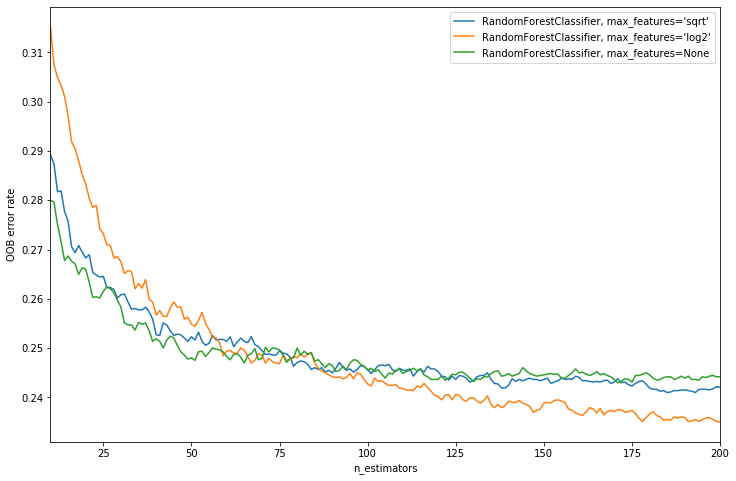

In [16]:
import matplotlib.pyplot as plt

from collections import OrderedDict
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier

print(__doc__)

RANDOM_STATE = 123

# pipeline = make_pipeline(vec, scaler, clf)

# NOTE: Setting the `warm_start` construction parameter to `True` disables
# support for parallelized ensembles but is necessary for tracking the OOB
# error trajectory during training.
ensemble_pipelines = [
    ("RandomForestClassifier, max_features='sqrt'",
         make_pipeline(vec, scaler, 
                       RandomForestClassifier(warm_start=True, oob_score=True,
                               max_features="sqrt",
                               random_state=RANDOM_STATE))),
    ("RandomForestClassifier, max_features='log2'",
         make_pipeline(vec, scaler,
                       RandomForestClassifier(warm_start=True, max_features='log2',
                               oob_score=True,
                               random_state=RANDOM_STATE))),
    ("RandomForestClassifier, max_features=None",
         make_pipeline(vec, scaler,
                       RandomForestClassifier(warm_start=True, max_features=None,
                               oob_score=True,
                               random_state=RANDOM_STATE)))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_pipelines)

# Range of `n_estimators` values to explore.
min_estimators = 10
max_estimators = 200

for label, clf in ensemble_pipelines:
    for i in range(min_estimators, max_estimators + 1):
        clf[2].set_params(n_estimators=i)
        clf.fit(X, y)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf[2].oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

F = plt.gcf()
Size = F.get_size_inches()
F.set_size_inches(Size[0]*2, Size[1]*2, forward=True)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.savefig('oob-error-randomforest-100-500.png')
plt.show()

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(train_features, train_labels)

In [10]:
plt.savefig('oob-error-randomforest-15-175.png')

<Figure size 432x288 with 0 Axes>

In [7]:
from sklearn.pipeline import FeatureUnion, Pipeline, make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import Normalizer

class LabeledNormalizer(Normalizer):
    def fit(self, X, *args, **kwargs):
        try:
            self.names = X.columns
        except:
            self.names = [str(i) for i in range(X.shape[1])]
        return super().fit(X, *args, **kwargs)
         
    def get_feature_names(self):
        return self.names
    
vec = ColumnTransformer([
#     ('norm', LabeledNormalizer(), ['id']),
    ('kw', TfidfVectorizer(ngram_range=(1, 3), min_df=2, token_pattern=r"(?u)\b\w+\b",), 'keyword'),
    ('loc', TfidfVectorizer(ngram_range=(1, 3), min_df=2, token_pattern=r"(?u)\b\w+\b"), 'location'),
    ('text', TfidfVectorizer(ngram_range=(1, 3), min_df=2, token_pattern=r"(?u)\b\w+\b"), 'text'),
    ('ent', CountVectorizer(ngram_range=(1, 1), analyzer='word', token_pattern=r"(?u)\b\w+\b"), 'entities'),
    ('label', CountVectorizer(ngram_range=(1, 1), analyzer='word', token_pattern=r"(?u)\b\w+\b"), 'labels'),
    ('dep', CountVectorizer(ngram_range=(1, 1), analyzer='word', token_pattern=r"(?u)\b\w+\b"), 'ent_dep'),
    ('head', CountVectorizer(ngram_range=(1, 1), analyzer='word', token_pattern=r"(?u)\b\w+\b"), 'ent_head'),
    ('pos', CountVectorizer(ngram_range=(1, 1), analyzer='word', token_pattern=r"(?u)\b\w+\b"), 'ent_pos'),
    ('child', CountVectorizer(ngram_range=(1, 1), analyzer='word', token_pattern=r"(?u)\b\w+\b"), 'ent_children'),
    
])

# from sklearn.svm import LinearSVC
# from sklearn.svm import SVC
# clf = SVC(kernel='linear', probability=True)
# clf = SVC(kernel='rbf', probability=True)
# clf = SVC(kernel='poly', probability=True)
# clf = LinearSVC(verbose=True)

from sklearn.ensemble import RandomForestClassifier
# clf = RandomForestClassifier(n_estimators=20, random_state=0) # use a guassian forest
clf = RandomForestClassifier(n_estimators=200, random_state=0)
# clf = RandomForestClassifier(n_estimators=500, random_state=0) # parallel all jobs

from sklearn import preprocessing
scaler = preprocessing.StandardScaler(with_mean=False)

pipeline = make_pipeline(vec, scaler, clf)

# pipeline = make_pipeline(vec, clf)

## select features

In [5]:
pipeline.fit(X, y)

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('kw',
                                                  TfidfVectorizer(analyzer='word',
                                                                  binary=False,
                                                                  decode_error='strict',
                                                                  dtype=<class 'numpy.float64'>,
                                                                  encoding='utf-8',
                                                                  input='content',
                                                                  lowercase=True,
                                                                  max_df=1.0,
                        

In [12]:
feature_imp = pd.Series(pipeline[1].feature_importances_,index=pipeline[0].get_feature_names()).sort_values(ascending=False)

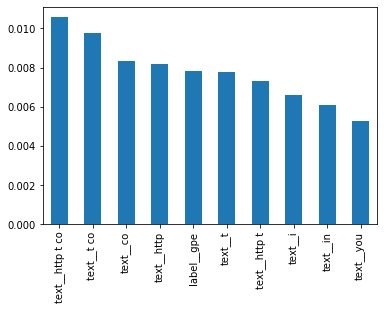

In [18]:
feature_imp[:10].plot(kind='bar')

## evaluation

In [8]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, cross_val_predict

def evaluate(_clf, X, y):
    report = classification_report(
        y_true=y, y_pred=cross_val_predict(pipeline, X, y, cv=5)
    )
    print(report)
    scores = cross_val_score(_clf, X, y, scoring='accuracy', cv=5)
    print('Cross-validation MSE: {:.3f} ± {:.3f}'.format(np.mean(scores), 2 * np.std(scores)))
    
    _clf.fit(X,y)
    print('Training Set Accuracy: {:.3f}'.format(_clf.score(X,y)))


import time
start_time = time.time()

evaluate(pipeline, X, y)

seconds = time.time() - start_time
print('\nEvaluation Time Taken: ', time.strftime("%H:%M:%S",time.gmtime(seconds)))

import time
start_time = time.time()

pipeline.fit(X,y)

seconds = time.time() - start_time
print('Training Time Taken:  ', time.strftime("%H:%M:%S",time.gmtime(seconds)))

              precision    recall  f1-score   support

           0       0.66      0.90      0.77      4342
           1       0.76      0.39      0.52      3271

    accuracy                           0.68      7613
   macro avg       0.71      0.65      0.64      7613
weighted avg       0.70      0.68      0.66      7613

Cross-validation MSE: 0.685 ± 0.060
Training Set Accuracy: 0.995

Evaluation Time Taken:  00:04:41
Training Time Taken:   00:00:35


## random forest

### 500 trees (original 9 features):
```
              precision    recall  f1-score   support

           0       0.67      0.91      0.77      4342
           1       0.76      0.40      0.52      3271

    accuracy                           0.69      7613
   macro avg       0.71      0.65      0.65      7613
weighted avg       0.71      0.69      0.66      7613

Cross-validation MSE: 0.689 ± 0.062
Training Set Accuracy: 0.995

Evaluation Time Taken:  00:12:53
Training Time Taken:   00:01:37
```

### 200 trees (original features):
```
              precision    recall  f1-score   support

           0       0.67      0.91      0.77      4342
           1       0.77      0.41      0.53      3271

    accuracy                           0.69      7613
   macro avg       0.72      0.66      0.65      7613
weighted avg       0.71      0.69      0.67      7613

Cross-validation MSE: 0.692 ± 0.066
Training Set Accuracy: 0.995

Evaluation Time Taken:  00:05:43
Training Time Taken:   00:00:45
```

### 20 trees (original features):
```
              precision    recall  f1-score   support

           0       0.66      0.90      0.76      4342
           1       0.75      0.39      0.51      3271

    accuracy                           0.68      7613
   macro avg       0.71      0.65      0.64      7613
weighted avg       0.70      0.68      0.66      7613

Cross-validation MSE: 0.682 ± 0.060
Training Set Accuracy: 0.987

Evaluation Time Taken:  00:00:49
Training Time Taken:   00:00:05
```

## rbf kernel

```
              precision    recall  f1-score   support

           0       0.65      0.85      0.74      4342
           1       0.67      0.40      0.50      3271

    accuracy                           0.66      7613
   macro avg       0.66      0.63      0.62      7613
weighted avg       0.66      0.66      0.64      7613

Cross-validation MSE: 0.657 ± 0.070
Training Set Accuracy: 0.902

Evaluation Time Taken: 00:09:49
Training Time Taken:   00:01:21
```


## polynomial kernel
```
              precision    recall  f1-score   support

           0       0.64      0.92      0.75      4342
           1       0.74      0.30      0.43      3271

    accuracy                           0.65      7613
   macro avg       0.69      0.61      0.59      7613
weighted avg       0.68      0.65      0.61      7613

Cross-validation MSE: 0.655 ± 0.035
Training Set Accuracy: 0.873

Evaluation Time Taken: 00:11:37
Training Time Taken:   00:01:15
```

# Conclusion:
1. Random forest is the best method so far;
2. Ensemble 500 trees will cause overfitting.

In [16]:
from sklearn.externals import joblib

pipeline.fit(X, y)

rf_mdl = '../models/random-forest-200.pkl'
joblib.dump(pipeline, rf_mdl)
!ls -lSh $rf_mdl

/usr/local/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


-rw-r--r-- 1 hongyu hongyu 64M Mar 26 00:48 ../models/random-forest-200.pkl


----

In [35]:
from sklearn.pipeline import FeatureUnion, Pipeline, make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import LabelBinarizer
from sklearn import preprocessing

class LabeledNormalizer(Normalizer):
    def fit(self, X, *args, **kwargs):
        try:
            self.names = X.columns
        except:
            self.names = [str(i) for i in range(X.shape[1])]
        return super().fit(X, *args, **kwargs)
         
    def get_feature_names(self):
        return self.names
    
class SupervisionFriendlyLabelBinarizer(LabelBinarizer):
    def fit_transform(self, X, y=None):
        return super(SupervisionFriendlyLabelBinarizer,self).fit_transform(X)

class MultiLabelBinarizerWrapper(MultiLabelBinarizer):
    def fit_transform(self, X, y=None):
        return super(MultiLabelBinarizerWrapper,self).fit_transform(X)
    def get_params(self, deep=True):
        return super(MultiLabelBinarizer,self).get_params(deep=True)

# enc = OneHotEncoder(handle_unknown='ignore')
# lb = preprocessing.LabelBinarizer()

vec = ColumnTransformer([
#     ('norm', LabeledNormalizer(), ['id']),
    ('kw', TfidfVectorizer(ngram_range=(1, 1), min_df=2, token_pattern=r"(?u)\b\w+\b",), 'keyword'),
    ('loc', TfidfVectorizer(ngram_range=(1, 1), min_df=2, token_pattern=r"(?u)\b\w+\b"), 'location'),
    ('text', TfidfVectorizer(ngram_range=(1, 3), min_df=2, token_pattern=r"(?u)\b\w+\b"), 'text'),
    ('ent', CountVectorizer(ngram_range=(1, 1), analyzer='word', token_pattern=r"(?u)\b\w+\b"), 'entities'),
    ('label', CountVectorizer(ngram_range=(1, 1), analyzer='word', token_pattern=r"(?u)\b\w+\b"), 'labels'),
    ('dep', CountVectorizer(ngram_range=(1, 1), analyzer='word', token_pattern=r"(?u)\b\w+\b"), 'ent_dep'),
    ('head', CountVectorizer(ngram_range=(1, 1), analyzer='word', token_pattern=r"(?u)\b\w+\b"), 'ent_head'),
    ('pos', CountVectorizer(ngram_range=(1, 1), analyzer='word', token_pattern=r"(?u)\b\w+\b"), 'ent_pos'),
    ('child', CountVectorizer(ngram_range=(1, 1), analyzer='word', token_pattern=r"(?u)\b\w+\b"), 'ent_children'),
    ('hash', MultiLabelBinarizerWrapper(), 'hashtag'),
    ('hashl1', SupervisionFriendlyLabelBinarizer(), 'hashtags_have_l1_synonyms'),
    ('hashl2', SupervisionFriendlyLabelBinarizer(), 'hashtags_have_l2_synonyms'),
    ('subj', MultiLabelBinarizerWrapper(), 'subj'),
    ('obj', MultiLabelBinarizerWrapper(), 'verb'),
    ('verb', MultiLabelBinarizerWrapper(), 'obj'),
    ('syn1', SupervisionFriendlyLabelBinarizer(), 'contains_l1_synonyms'),
    ('syn2', SupervisionFriendlyLabelBinarizer(), 'contains_l2_synonyms'),
    ('damage', SupervisionFriendlyLabelBinarizer(), 'contains_damaged_words'),
    ('news', SupervisionFriendlyLabelBinarizer(), 'mentioned_news_org'),
    ('relief', SupervisionFriendlyLabelBinarizer(), 'mentioned_relief_org'),
    ('mentions', MultiLabelBinarizerWrapper(), 'mentions'),
#     ('orgs', MultiLabelBinarizerWrapper, 'orgs'),
#     ('gpes', MultiLabelBinarizerWrapper, 'gpes'),
#     ('facs', MultiLabelBinarizerWrapper, 'facs'),
    
])

# from sklearn.preprocessing import PolynomialFeatures
# poly = PolynomialFeatures(2)

# from sklearn.svm import LinearSVC
from sklearn.svm import SVC
# clf = SVC(kernel='linear', probability=True)
clf = SVC(kernel='rbf', probability=True)

# from sklearn.ensemble import RandomForestClassifier
# clf = RandomForestClassifier(n_estimators=20, random_state=0) # use a guassian forest
clf = RandomForestClassifier(n_estimators=1000, max_features=1000, random_state=0) # set limit to prevent overfitting
# clf = RandomForestClassifier(n_estimators=200, max_features=1000, random_state=0) # set limit to prevent overfitting
# scaler = preprocessing.StandardScaler(with_mean=False)

# from sklearn.neural_network import MLPClassifier
# clf = MLPClassifier(solver='lbfgs', alpha=1e-5, activation='tanh', hidden_layer_sizes=(50, 100, 30), max_iter=1000, random_state=1)

pipeline = make_pipeline(vec, scaler, clf)
# pipeline = make_pipeline(vec, clf)


# add new features

In [36]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, cross_val_predict

def evaluate(_clf, X, y):
    report = classification_report(
        y_true=y, y_pred=cross_val_predict(pipeline, X, y, cv=5)
    )
    print(report)
    scores = cross_val_score(_clf, X, y, scoring='accuracy', cv=5)
    print('Cross-validation MSE: {:.3f} ± {:.3f}'.format(np.mean(scores), 2 * np.std(scores)))
    
    _clf.fit(X,y)
    print('Training Set Accuracy: {:.3f}'.format(_clf.score(X,y)))


import time
start_time = time.time()

evaluate(pipeline, X, y)

seconds = time.time() - start_time
print('\nEvaluation Time Taken: ', time.strftime("%H:%M:%S",time.gmtime(seconds)))

import time
start_time = time.time()

pipeline.fit(X,y)

seconds = time.time() - start_time
print('Training Time Taken:  ', time.strftime("%H:%M:%S",time.gmtime(seconds)))

/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:987: UserWarning: unknown class(es) ['/', '´'] will be ignored
  .format(sorted(unknown, key=str)))
/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:987: UserWarning: unknown class(es) ['='] will be ignored
  .format(sorted(unknown, key=str)))
/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:987: UserWarning: unknown class(es) ['7', '?', '¢', 'ã'] will be ignored
  .format(sorted(unknown, key=str)))
/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:987: UserWarning: unknown class(es) ['â'] will be ignored
  .format(sorted(unknown, key=str)))
/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:987: UserWarning: unknown class(es) ['"', '/'] will be ignored
  .format(sorted(unknown, key=str)))
/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:987: UserWarning: unknown class(es) ['Ê', 'Ó'] will be ignored
  .format(s

              precision    recall  f1-score   support

         0.0       0.69      0.87      0.77      4305
         1.0       0.73      0.48      0.58      3198

    accuracy                           0.70      7503
   macro avg       0.71      0.67      0.68      7503
weighted avg       0.71      0.70      0.69      7503



/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:987: UserWarning: unknown class(es) ['/', '´'] will be ignored
  .format(sorted(unknown, key=str)))
/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:987: UserWarning: unknown class(es) ['='] will be ignored
  .format(sorted(unknown, key=str)))
/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:987: UserWarning: unknown class(es) ['7', '?', '¢', 'ã'] will be ignored
  .format(sorted(unknown, key=str)))
/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:987: UserWarning: unknown class(es) ['â'] will be ignored
  .format(sorted(unknown, key=str)))
/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:987: UserWarning: unknown class(es) ['"', '/'] will be ignored
  .format(sorted(unknown, key=str)))
/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:987: UserWarning: unknown class(es) ['Ê', 'Ó'] will be ignored
  .format(s

Cross-validation MSE: 0.703 ± 0.049
Training Set Accuracy: 0.998

Evaluation Time Taken:  00:33:38
Training Time Taken:   00:03:32


## 21 NLP features, 12 of which are new 

### 500 trees with 1000 feature restriction (BEST so far)
```
              precision    recall  f1-score   support

         0.0       0.70      0.87      0.77      4305
         1.0       0.74      0.49      0.59      3198

    accuracy                           0.71      7503
   macro avg       0.72      0.68      0.68      7503
weighted avg       0.71      0.71      0.69      7503

Cross-validation MSE: 0.707 ± 0.046
Training Set Accuracy: 0.998

Evaluation Time Taken:  00:24:08
Training Time Taken:   00:01:48
```

### 500 trees with 2000 feature restriction
```
              precision    recall  f1-score   support

         0.0       0.69      0.86      0.77      4305
         1.0       0.72      0.49      0.59      3198

    accuracy                           0.70      7503
   macro avg       0.71      0.68      0.68      7503
weighted avg       0.71      0.70      0.69      7503

Cross-validation MSE: 0.702 ± 0.047
Training Set Accuracy: 0.998

Evaluation Time Taken:  00:29:48
Training Time Taken:   07:16:38
```

### 600 trees with 2000 feature restriction
```
              precision    recall  f1-score   support

         0.0       0.69      0.87      0.77      4305
         1.0       0.73      0.48      0.58      3198

    accuracy                           0.70      7503
   macro avg       0.71      0.68      0.68      7503
weighted avg       0.71      0.70      0.69      7503

Cross-validation MSE: 0.705 ± 0.052
Training Set Accuracy: 0.998

Evaluation Time Taken:  00:27:49
Training Time Taken:   00:03:17
```
----
### 500 trees
```
              precision    recall  f1-score   support

         0.0       0.68      0.90      0.78      4305
         1.0       0.77      0.44      0.56      3198

    accuracy                           0.70      7503
   macro avg       0.73      0.67      0.67      7503
weighted avg       0.72      0.70      0.68      7503

Cross-validation MSE: 0.705 ± 0.053
Training Set Accuracy: 0.998

Evaluation Time Taken:  00:11:05
Training Time Taken:   00:01:12
```

### 200 trees
```
              precision    recall  f1-score   support

         0.0       0.68      0.89      0.77      4305
         1.0       0.75      0.44      0.55      3198

    accuracy                           0.70      7503
   macro avg       0.72      0.67      0.66      7503
weighted avg       0.71      0.70      0.68      7503

Cross-validation MSE: 0.699 ± 0.050
Training Set Accuracy: 0.998

Evaluation Time Taken:  00:04:22
Training Time Taken:   00:00:35
```

In [28]:
from sklearn.externals import joblib

pipeline.fit(X, y)

rf_21_mdl = '../models/random-forest-21-features.pkl'
joblib.dump(pipeline, rf_21_mdl)
!ls -lSh $rf_21_mdl

/usr/local/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


-rw-r--r-- 1 hongyu hongyu 96M Mar 28 22:57 ../models/random-forest-21-features.pkl
